In [38]:
#%pip install matplotlib

#%pip install scikit-learn
#%pip install catboost 


import pandas as pd
import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt

from cycler import cycler


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from itertools import combinations


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestRegressor

# Clustering Exercise (30 points) ✔
## Abschlussbedingungen
- Geöffnet: Dienstag, 11. Juni 2024, 17:00
- Fällig: Dienstag, 30. Juli 2024, 00:00
## Objective
To categorize the countries using socio-economic and health factors that determine the overall development of the country.

## Problem Statement:
HELP International has been able to raise around $ 10 million. Now the CEO of the NGO needs to decide how to use this money strategically and effectively.  Hence, your Job as a Data scientist is to categorize the countries using some socio-economic and health factors that determine the overall development of the country.

##Data


In [3]:
dataURL= "https://raw.githubusercontent.com/WHPAN0108/BHT-DataScience-S23/main/clustering/data/country.txt"
#"https://github.com/WHPAN0108/BHT-DataScience-S23/blob/main/clustering/data/country.txt"


Country information
- country
- child_mort,
- exports,
- health,
- imports,
- income,
- inflation,
- life_expec,
- total_fer,
- gdpp


##Task:


In [4]:
data = pd.read_csv(dataURL, delimiter=',')
data.describe(include='all')

country  child_mort     exports      health     imports  \
count        151  151.000000  151.000000  151.000000  151.000000   
unique       151         NaN         NaN         NaN         NaN   
top     Mongolia         NaN         NaN         NaN         NaN   
freq           1         NaN         NaN         NaN         NaN   
mean         NaN   37.905960   40.447013    6.790530   46.351430   
std          NaN   40.749021   28.196914    2.781353   24.614163   
min          NaN    2.600000    0.109000    1.810000    0.065900   
25%          NaN    7.850000   22.800000    4.850000   29.950000   
50%          NaN   19.100000   34.800000    6.220000   43.000000   
75%          NaN   60.400000   50.950000    8.690000   57.500000   
max          NaN  208.000000  200.000000   17.900000  174.000000   

               income   inflation  life_expec   total_fer           gdpp  
count      151.000000  151.000000  151.000000  151.000000     151.000000  
unique            NaN         NaN         NaN         NaN            NaN  
top               NaN         NaN         NaN         NaN            NaN  
freq              NaN         NaN         NaN         NaN            NaN  
mean     17899.423841    7.857536   70.774172    2.934305   13636.324503  
std      19801.730058   10.973978    9.011529    1.512132   18766.269648  
min        609.000000   -4.210000   32.100000    1.150000     231.000000  
25%       3850.000000    1.730000   65.450000    1.820000    1485.000000  
50%      10400.000000    5.140000   73.400000    2.410000    5020.000000  
75%      26200.000000   10.350000   77.000000    3.750000   16850.000000  
max     125000.000000  104.000000   82.800000    7.490000  105000.000000


1. use K-means clustering and Hierarchical clustering to cluster the country into groups.

I'm, gonna first use Child Mortality in conjunction with lif expectency to create the clusters.

In [92]:
features_all = data[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
#features = data[['child_mort', 'life_expec']]

# Scaling the features
scaler = StandardScaler()
features_scaled_all = scaler.fit_transform(features_all)
scaledFeaturesFrame = pd.DataFrame(features_scaled_all, columns=features_all.columns)



In [95]:
scaledFeaturesFrame.head(500)

child_mort   exports    health   imports    income  inflation  \
0     -0.290688  0.222499 -0.487182  0.421831 -0.516285   2.865576   
1      0.955192 -0.738239 -0.169736 -1.188277 -0.736187   1.073589   
2      1.294977 -0.627932 -0.072338 -0.466786 -0.854752   0.387880   
3     -0.822526  1.279311  1.410278  1.155551  1.175543  -0.546514   
4      1.922842  0.023235  0.403831  0.132419 -0.876083   1.183302   
..          ...       ...       ...       ...       ...        ...   
146   -0.859459 -0.062164  0.778994 -0.364880  1.109674  -0.686307   
147   -0.682180 -0.257870  1.482424 -0.462709 -0.248247  -0.117717   
148   -0.475354 -0.873454  0.288396 -1.163820 -0.354652  -0.365486   
149   -0.765895 -0.122655  0.836711  0.666404 -0.197579  -0.572113   
150   -0.849610  0.909249  0.393009  0.674556  0.526984  -0.849140   

     life_expec  total_fer      gdpp  
0     -0.509280  -0.195277 -0.587378  
1     -0.498146   1.291005 -0.649931  
2     -1.967811   1.576318 -0.704518  
3      1.027187  -0.712821  1.644762  
4     -1.477923   2.392446 -0.711201  
..          ...        ...       ...  
146    1.027187  -0.706186  1.740998  
147    1.071723  -0.673010 -0.290650  
148    0.626370  -0.613293 -0.394906  
149    0.626370  -0.772538 -0.371916  
150    0.748842  -0.945053  0.329537  

[151 rows x 9 columns]

## I was first trying to get a broad overview of the different feature subsets for clustering, but graphing those got confusing:

In [96]:
def get_all_subsets(lst):
    subsets = []
    for i in range(len(lst) + 1):
        for combo in combinations(lst, i):
            subsets.append(list(combo))
    return subsets

def getdata(cols):
    return scaledFeaturesFrame[cols]

In [97]:
featureList_all = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']
subsets = get_all_subsets(featureList_all)
datalist = list(map(getdata, subsets))

In [98]:
inertiaKMeans = []
for i in range(len(datalist)):
    subset = subsets[i]
    featurecombdata = datalist[i]
    if (len(subset) == 0):
        inertiaKMeans.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
        continue;
    
    inertia = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(featurecombdata)
        inertia.append(kmeans.inertia_)
    inertiaKMeans.append(inertia)

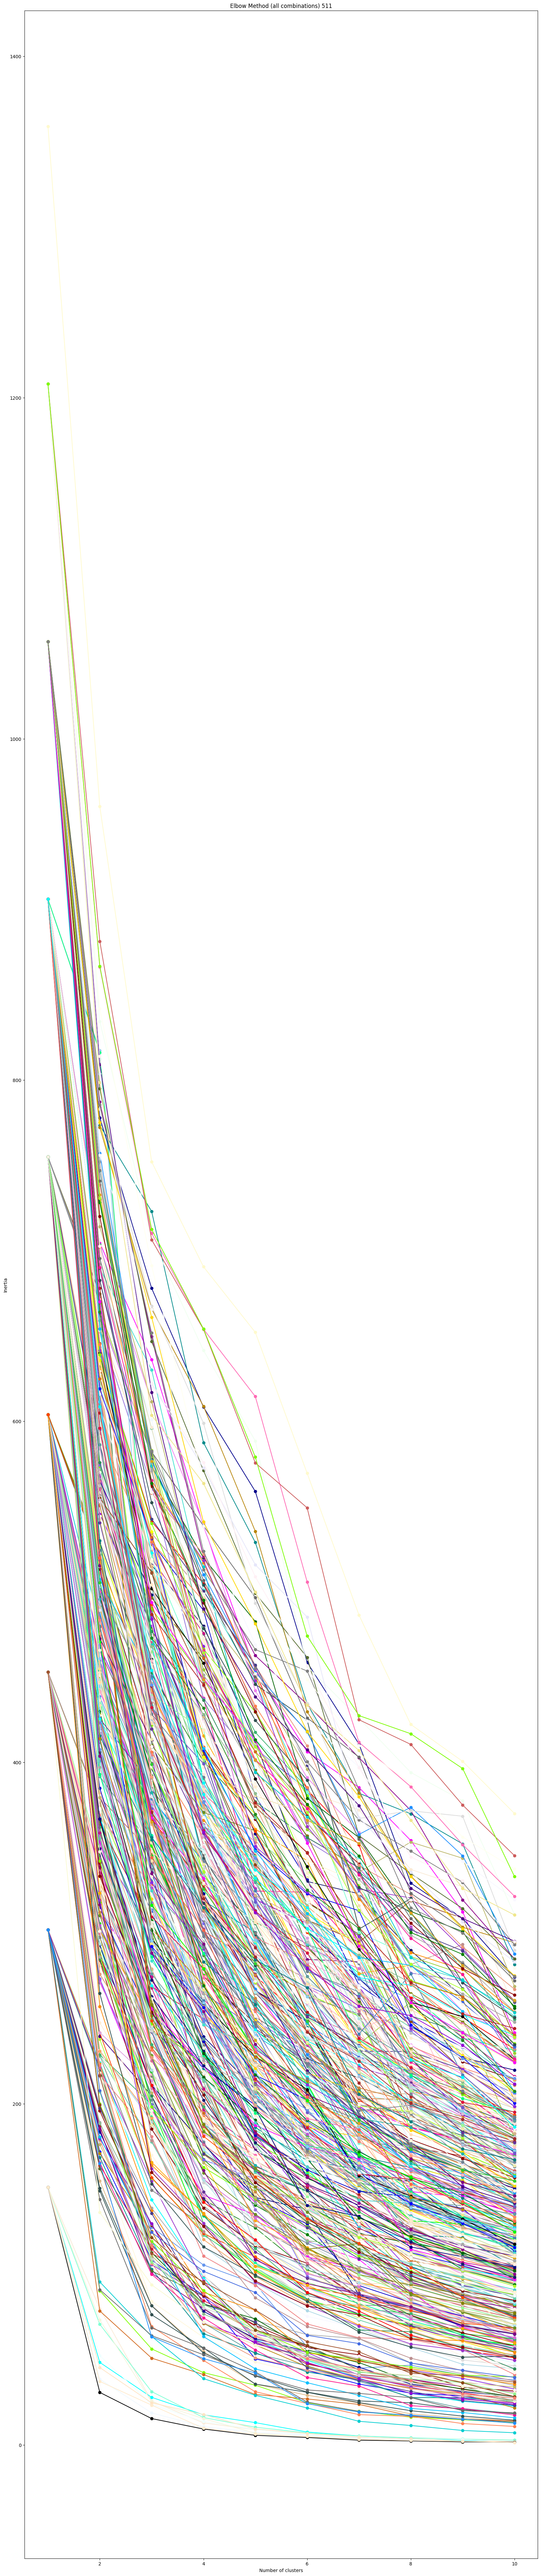

In [100]:
def annotate_line_ends(label, x, y, offset_start, offset_end):
    # Annotate the start of the line
    plt.annotate(label,
                 (x, y),
                 #textcoords="offset points",
                 xytext=offset_start,
                 ha='center')
    # Annotate the end of the line
    # plt.annotate(label,
    #              (x, y),
    #              textcoords="offset points",
    #              xytext=offset_end,
    #              ha='center')

plt.figure(figsize=(20, 100))

custom_colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
custom_colors = matplotlib.colors.CSS4_COLORS.keys()

# Set the custom color cycle
plt.rc('axes', prop_cycle=(cycler('color', custom_colors)))

for i in range(len(datalist)):
    subset = subsets[i]
    if (len(subset) == 0) : continue
    inertia = inertiaKMeans[i]
    subsetstr = str(subset)
    plt.plot(range(1, 11), inertia, marker='o', label=subsetstr)

for i in range(len(datalist)):
    subset = subsets[i]
    if (len(subset) == 0) : continue
    inertia = inertiaKMeans[i]
    subsetstr = str(subset)
    annotate_line_ends(subsetstr, 0.0, inertia[0], (-30, 5), (30, 5))
    annotate_line_ends(subsetstr, 11.0, inertia[-1], (-30, -15), (30, -15))

plt.title('Elbow Method (all combinations) ' + str(len(datalist)-1))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
#plt.yscale('log')
#plt.legend(loc=(1, 0), ncol=2)
plt.show()

## So i decided to use only child mortality and life expectancy, for now:

In [101]:
#features = data[['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']]
features = data[['child_mort', 'life_expec']]

# Scaling the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [104]:
features_scaled

array([[-0.29068792, -0.50928027],
       [ 0.95519199, -0.49814644],
       [ 1.29497742, -1.96781118],
       [-0.82252599,  1.02718741],
       [ 1.92284181, -1.47792293],
       [-0.75358401,  0.8824477 ],
       [ 0.2140658 ,  0.09194621],
       [-0.46304285,  0.82677858],
       [-0.52706039,  0.2255521 ],
       [ 1.52150104, -2.70264354],
       [ 1.37130603, -1.45565528],
       [-0.76097065,  0.52616534],
       [-0.47042949,  0.06967857],
       [ 1.46487014, -0.28660379],
       [ 1.33437284, -0.60948468],
       [-0.79790385, -0.04165967],
       [ 0.59817107, -0.88783027],
       [-0.44826957,  0.78224328],
       [-0.11340856, -0.09732879],
       [-0.10848414,  0.30348886],
       [ 3.00621564, -1.75626852],
       [ 0.60801992,  0.03627709],
       [-0.33993219, -0.60948468],
       [ 1.23834652, -0.54268174],
       [-0.59354015,  0.33689034],
       [-0.68710426, -0.17526556],
       [-0.46796727,  0.08081239],
       [-0.85453476,  0.97151829],
       [-0.5467581 ,

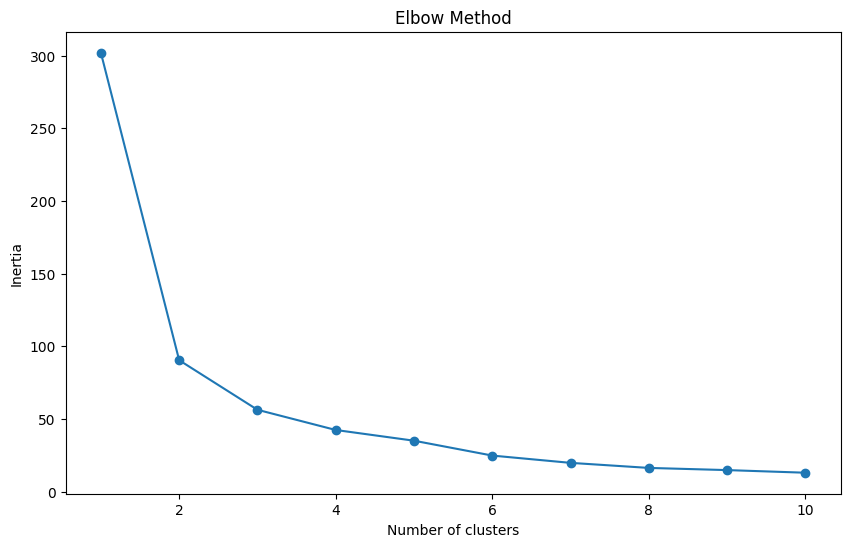

In [108]:
# Choosing the number of clusters with the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
plt.rc('axes', prop_cycle=plt.rcParamsDefault['axes.prop_cycle'])

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The trajectory of the curve starts to flatten at 3, so i'll pick three clusters.
I'm now getting the clusters:

In [112]:
k = 6

# Applying K-Means clustering
kmeans = KMeans(n_clusters=k, random_state=42)
data['Cluster'] = kmeans.fit_predict(features_scaled)

# Analyzing the clusters
for i in range(k):
    print(f"Countries in cluster {i}:")
    print(data[data['Cluster'] == i]['country'].values)

Countries in cluster 0:
['Belgium' 'United States' 'Slovenia' 'Lebanon' 'United Kingdom' 'Italy'
 'France' 'Portugal' 'Norway' 'Sweden' 'New Zealand' 'Kuwait' 'Cyprus'
 'Germany' 'Malta' 'Ireland' 'South Korea' 'Denmark' 'Greece' 'Chile'
 'Australia' 'Singapore' 'Japan' 'Iceland' 'Canada' 'Austria' 'Luxembourg'
 'Israel' 'Qatar' 'Switzerland' 'Spain' 'Finland' 'Costa Rica'
 'Czech Republic']
Countries in cluster 1:
['Sierra Leone' 'Haiti' 'Central African Republic']
Countries in cluster 2:
['Mongolia' 'Bolivia' 'Indonesia' 'Timor-Leste' 'Fiji' 'Egypt' 'Guatemala'
 'Iraq' 'Guyana' 'Micronesia, Fed. Sts.' 'Nepal' 'Turkmenistan'
 'Philippines' 'Suriname' 'Vanuatu' 'Bangladesh' 'India' 'Kazakhstan'
 'Yemen' 'Kyrgyz Republic' 'Bhutan' 'Tajikistan' 'Azerbaijan']
Countries in cluster 3:
['Sudan' 'Mauritania' 'Pakistan' 'Kenya' 'Comoros' 'Madagascar' 'Eritrea'
 'Uganda' 'Botswana' 'Myanmar' 'Gambia' 'Ghana' 'Rwanda' 'South Africa'
 'Congo, Rep.' 'Liberia' 'Tanzania' 'Lao' 'Namibia' 'Kiribati']


2. use PCA to reduce the dimension to 2d, and visualize the cluster from K-means and Hierarchical clustering respectively



3. please write the suggestion to CEO about the country you suggest




It is from Kaggle, but the data has been modified.